In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/shelf_life.zip'

Archive:  /content/drive/MyDrive/shelf_life.zip
   creating: shelf_life/
   creating: shelf_life/Apple(1-5)/
  inflating: shelf_life/Apple(1-5)/frame1000.jpg  
  inflating: shelf_life/Apple(1-5)/frame1010.jpg  
  inflating: shelf_life/Apple(1-5)/frame1020.jpg  
  inflating: shelf_life/Apple(1-5)/frame1030.jpg  
  inflating: shelf_life/Apple(1-5)/frame1040.jpg  
  inflating: shelf_life/Apple(1-5)/frame1050.jpg  
  inflating: shelf_life/Apple(1-5)/frame1060.jpg  
  inflating: shelf_life/Apple(1-5)/frame1070.jpg  
  inflating: shelf_life/Apple(1-5)/frame1080.jpg  
  inflating: shelf_life/Apple(1-5)/frame1090.jpg  
  inflating: shelf_life/Apple(1-5)/frame1100.jpg  
  inflating: shelf_life/Apple(1-5)/frame1110.jpg  
  inflating: shelf_life/Apple(1-5)/frame1120.jpg  
  inflating: shelf_life/Apple(1-5)/frame1130.jpg  
  inflating: shelf_life/Apple(1-5)/frame1140.jpg  
  inflating: shelf_life/Apple(1-5)/frame1150.jpg  
  inflating: shelf_life/Apple(1-5)/frame1160.jpg  
  inflating: shelf_life/

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Image path and class labels
image_path = '/content/shelf_life'
fress_life = ['Apple_1_5', 'Apple_5_10', 'Apple_10_14', 'Banana_1_5', 'Banana_5_10', 'Banana_10_15',
              'Banana_15_20', 'Carrot_1_2', 'Carrot_3_4', 'carrot_5_6', 'Tomato_1_5', 'Tomato_5_10',
              'Tomato_10_15', 'Expired']

# Function to load data
def load_data(PATH):
    filenames, fresh = [], []

    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            p = file.replace('(', '_').replace(')', '').replace('-', '_')
            fresh.append(fress_life.index(p))
            filenames.append(os.path.join(PATH, file, img))

    df = pd.DataFrame({
        'filename': filenames,
        'fresh': fresh
    })

    return df

In [7]:
# Load dataset
df_img = load_data(image_path).sample(frac=1)
df_train, df_val = train_test_split(df_img, test_size=0.20, stratify=df_img['fresh'])

# Function to load and resize images
def load_image(path):
    img = plt.imread(path)
    if len(img.shape) == 2:  # Convert grayscale to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[-1] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    target_size = (32, 32)
    re_img = cv2.resize(img, target_size)
    return re_img

# Load training and validation data
x_train = np.array([load_image(i) for i in df_train['filename'].tolist()])
y_train = np.array(df_train['fresh'].tolist())
x_test = np.array([load_image(i) for i in df_val['filename'].tolist()])
y_test = np.array(df_val['fresh'].tolist())

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

100%|██████████| 14/14 [00:00<00:00, 256.99it/s]


In [32]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [34]:
cnn = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  # No MaxPooling after this layer to prevent too much shrinking

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(len(fress_life), activation='softmax')  # Output layer
])

In [35]:
# Compile the model with a lower learning rate
cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [36]:
# Train the model with augmented data
cnn.fit(datagen.flow(x_train, y_train, batch_size=32),
        epochs=50,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping])

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.1957 - loss: 2.8270 - val_accuracy: 0.2750 - val_loss: 3.0994
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3924 - loss: 1.9915 - val_accuracy: 0.1827 - val_loss: 3.3833
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4298 - loss: 1.7738 - val_accuracy: 0.1481 - val_loss: 3.4505
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4689 - loss: 1.6114 - val_accuracy: 0.1712 - val_loss: 3.6680
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5115 - loss: 1.4406 - val_accuracy: 0.3365 - val_loss: 2.1174
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5407 - loss: 1.2743 - val_accuracy: 0.3654 - val_loss: 2.0642
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5270 - loss: 1.2820 - val_accuracy: 0.4846 - val_loss: 1.5732
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5916 - loss: 1.1251 - val_accuracy: 0.4865 -

In [39]:
cnn.evaluate(x_test, y_test,batch_size=32)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7006 - loss: 0.7176


[0.744066596031189, 0.692307710647583]

In [38]:
cnn.save("model1.h5")

In [51]:
accu = 0.744066596031189
while True:
    cnn.fit(datagen.flow(x_train, y_train, batch_size=32),
            epochs=50,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping],
            verbose=0)

    newacc = cnn.evaluate(x_test, y_test, batch_size=32)

    if newacc[1] > accu:
        accu = newacc[1]
        model_path = f"/content/drive/My Drive/model{accu:.3f}.keras"  # Specify your path here
        cnn.save(model_path)

    if accu > 0.95:
        break

    print(newacc[1])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7885 - loss: 0.5364
0.7884615659713745
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7846 - loss: 0.4756
0.7961538434028625
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4910 - loss: 1.8880
0.48076921701431274
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6348 - loss: 0.8345
0.6346153616905212
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7056 - loss: 0.6945
0.7076923251152039
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6913 - loss: 0.6535
0.682692289352417
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5116 - loss: 2.0525
0.5076923370361328
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6449 - loss: 0.8425
0.6288461685180664
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7489 - loss: 0.5583
0.7461538314819336
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7126 - loss: 0.8238
0.692307710647583
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7149 - loss: 0.6690
0.717307

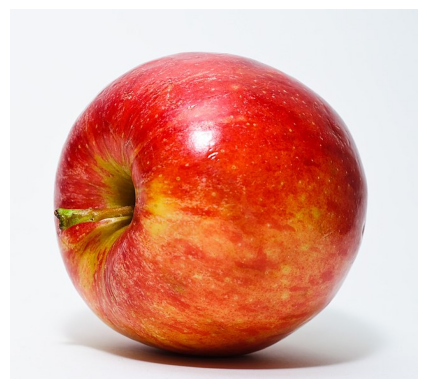

In [40]:
t_img=plt.imread('/content/Red_Apple.jpg')
plt.imshow(t_img)
plt.axis('OFF')
plt.show()

In [ ]:
target_size = (32, 32)
r_img = cv2.resize(t_img, target_size)
r_img = r_img / 255.0
r_img = np.expand_dims(r_img, axis=0)
y_pred=cnn.predict(r_img)

1/1 [==============================] - 0s 29ms/step


In [52]:
cnn=models.load_model('/content/drive/MyDrive/model0.904.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
fress_life[np.argmax(y_pred)]

'Apple_1_5'

In [53]:
def predictor(path):
    t_img=plt.imread(path)
    plt.imshow(t_img)
    plt.axis('OFF')
    plt.show()
    target_size = (32, 32)
    r_img = cv2.resize(t_img, target_size)
    r_img = r_img / 255.0
    r_img = np.expand_dims(r_img, axis=0)
    y_pred=cnn.predict(r_img)

    return fress_life[np.argmax(y_pred)]

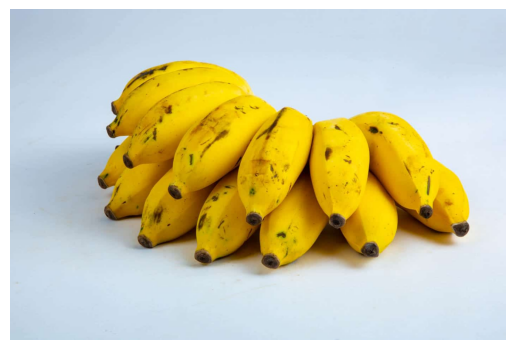

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Banana_1_5


In [59]:
print(predictor('/content/image7.jpg'))

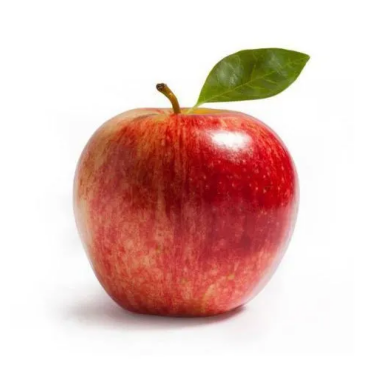

1/1 [==============================] - 0s 21ms/step
Tomato_5_10


In [ ]:
print(predictor('/home/puru/Downloads/mm.webp'))

In [ ]:
print(predictor('/home/puru/Downloads/tt.webd'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/puru/Downloads/tt.webd'